# Import

In [1]:
import sys
import os
from datetime import datetime

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import optim
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = True
out_dir = '../../out/sampling/ml_20m/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset

In [3]:
dataset = datasets.ML20m()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

# Device

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [5]:
print(device)

cuda:0


# Evaluator

In [6]:
# The size of recommendation set (K)
ks = [10]

# Compute average of 10 predictions score
n_prediction = 10

score_function_dict = {
    "Recall"        : evaluators.recall,
    "Unpopularity"  : evaluators.unpopularity,
    "Serendipity"   : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)

# Sampler

In [7]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [8]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Training

In [9]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [10]:
knn = searches.NearestNeighborhood(model)

In [11]:
re_base = pd.DataFrame()
for _ in range(n_prediction):
    trainer.valid(knn, userwise)
    _df = trainer.valid_scores.copy()
    re_base = pd.concat([re_base, _df])
re_base = re_base.mean()

In [32]:
re_base = re_base.to_frame().T

AttributeError: 'DataFrame' object has no attribute 'to_frame'

In [33]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(out_dir + file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.488223,910.545651,2.306424,0.13431


# MPCMP

In [13]:
# Hyperparameters
n_sample_li = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
bias_1 = 0.5
bias_2 = 0.8
gamma = distributions.Gamma()

In [14]:
rows_1 = []
rows_2 = []
for n_sample in n_sample_li:
    print(f'Processing... [n_sample = {n_sample}]')

    # α = 0.5
    row = pd.DataFrame()
    for _ in range(n_prediction):
        mp = searches.MutualProximity(model, gamma, n_sample, bias_1)
        trainer.valid(mp, userwise)
        _df = trainer.valid_scores.copy()
        row = pd.concat([row, _df])
    row_mean = row.mean().to_frame().T
    row_mean.insert(0, 'n_sample', n_sample)
    rows_1.append(row_mean)

    # α = 0.8
    row = pd.DataFrame()
    for _ in range(n_prediction):
        mp = searches.MutualProximity(model, gamma, n_sample, bias_2)
        trainer.valid(mp, userwise)
        _df = trainer.valid_scores.copy()
        row = pd.concat([row, _df])
    row_mean = row.mean().to_frame().T
    row_mean.insert(0, 'n_sample', n_sample)
    rows_2.append(row_mean)

re_mpcml_1 = pd.concat(rows_1)
re_mpcml_2 = pd.concat(rows_2)

Processing... [n_sample = 10]
Processing... [n_sample = 20]
Processing... [n_sample = 30]
Processing... [n_sample = 40]
Processing... [n_sample = 50]
Processing... [n_sample = 60]
Processing... [n_sample = 70]
Processing... [n_sample = 80]
Processing... [n_sample = 90]
Processing... [n_sample = 100]
Processing... [n_sample = 110]
Processing... [n_sample = 120]
Processing... [n_sample = 130]
Processing... [n_sample = 140]
Processing... [n_sample = 150]


In [15]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias1_%Y_%m_%d_%H%M.csv")
    re_mpcml_1.to_csv(out_dir + file_name, index=False)

display(re_mpcml_1)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10,n_sample
0,0.122814,3688.283165,2.203306,0.543217,10
0,0.106867,3891.957014,2.249977,0.573656,20
0,0.100045,3973.386118,2.246138,0.585665,30
0,0.096252,4018.128853,2.259606,0.592400,40
0,0.093681,4046.231914,2.248769,0.596599,50
0,0.091742,4066.901032,2.262853,0.599538,60
0,0.090432,4080.699864,2.257255,0.601708,70
0,0.089191,4092.991839,2.272395,0.603455,80
0,0.088374,4101.546927,2.272349,0.604745,90
0,0.087548,4108.820926,2.269039,0.605913,100


In [16]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias2_%Y_%m_%d_%H%M.csv")
    re_mpcml_2.to_csv(out_dir + file_name, index=False)

display(re_mpcml_2)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10,n_sample
0,0.273840,2471.654650,2.297851,0.365383,10
0,0.268100,2545.747341,2.337553,0.376560,20
0,0.265008,2577.962233,2.351251,0.381345,30
0,0.262588,2596.961206,2.354240,0.384170,40
0,0.261027,2609.018516,2.353932,0.385983,50
0,0.259886,2617.297380,2.375500,0.387280,60
0,0.258974,2623.737169,2.377036,0.388256,70
0,0.258111,2629.170465,2.376884,0.389041,80
0,0.257320,2633.874978,2.386247,0.389695,90
0,0.256728,2636.841531,2.386500,0.390184,100


## Show

In [34]:
# df -> list

k = 10
n_n_sample = len(n_sample_li)

# CML(Base)
recall_base           = re_base[f'Recall@{k}'].tolist() * n_n_sample
unpopularity_base     = re_base[f'Unpopularity@{k}'].tolist() * n_n_sample
serendipity_base      = re_base[f'Serendipity@{k}'].tolist() * n_n_sample
longtale_base         = re_base[f'Long-tail rate@{k}'].tolist() * n_n_sample

# MPCML (α = 0.5)
recall_mpcml_1        = re_mpcml_1[f'Recall@{k}'].tolist()
unpopularity_mpcml_1  = re_mpcml_1[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_1   = re_mpcml_1[f'Serendipity@{k}'].tolist()
longtale_mpcml_1      = re_mpcml_1[f'Long-tail rate@{k}'].tolist()

# MPCML (α = 0.8)
recall_mpcml_2        = re_mpcml_2[f'Recall@{k}'].tolist()
unpopularity_mpcml_2  = re_mpcml_2[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_2   = re_mpcml_2[f'Serendipity@{k}'].tolist()
longtale_mpcml_2      = re_mpcml_2[f'Long-tail rate@{k}'].tolist()

### Recall

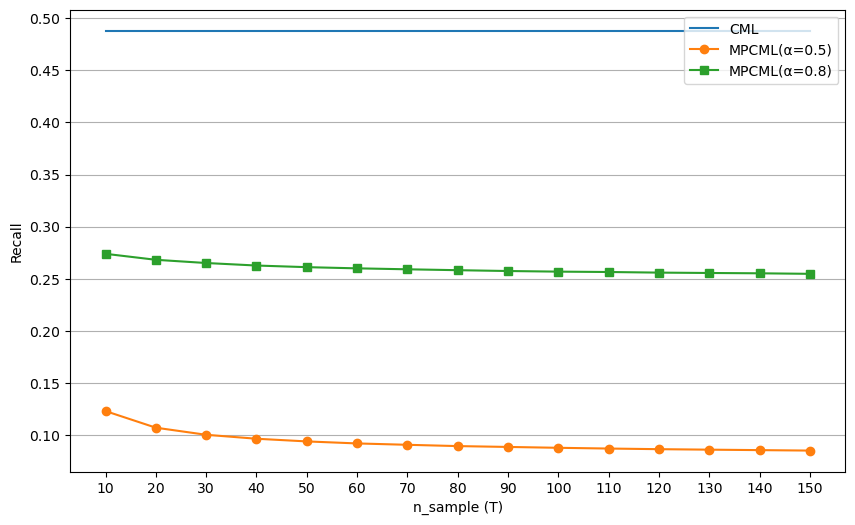

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, recall_base, label='CML')
plt.plot(n_sample_li, recall_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, recall_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (T)')
plt.ylabel('Recall')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("recall_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Unpopularity

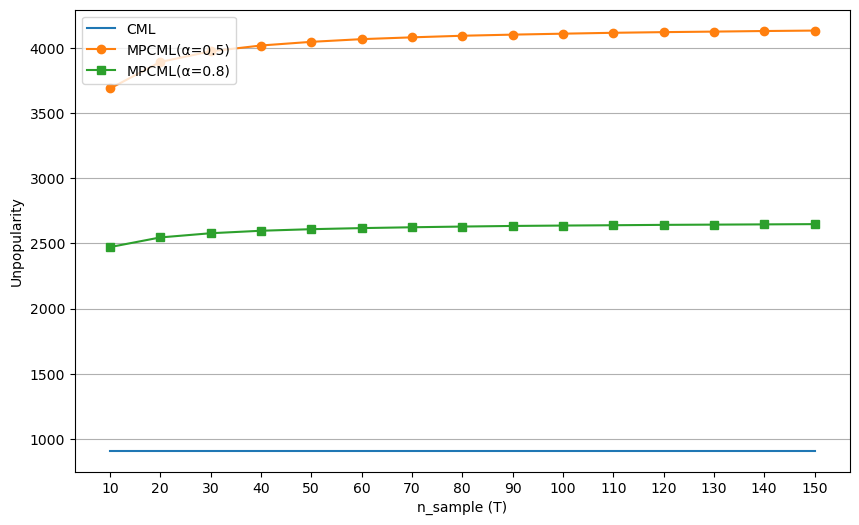

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, unpopularity_base, label='CML')
plt.plot(n_sample_li, unpopularity_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, unpopularity_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (T)')
plt.ylabel('Unpopularity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("unpopularity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

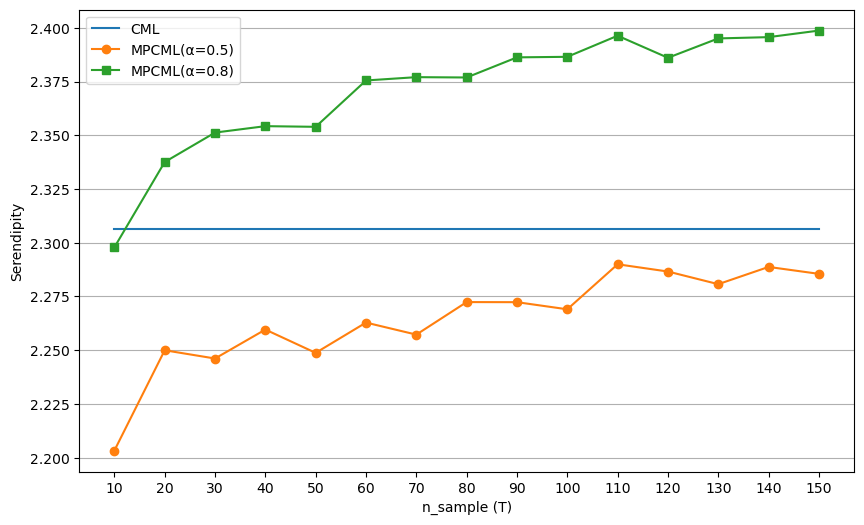

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, serendipity_base, label='CML')
plt.plot(n_sample_li, serendipity_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, serendipity_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (T)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

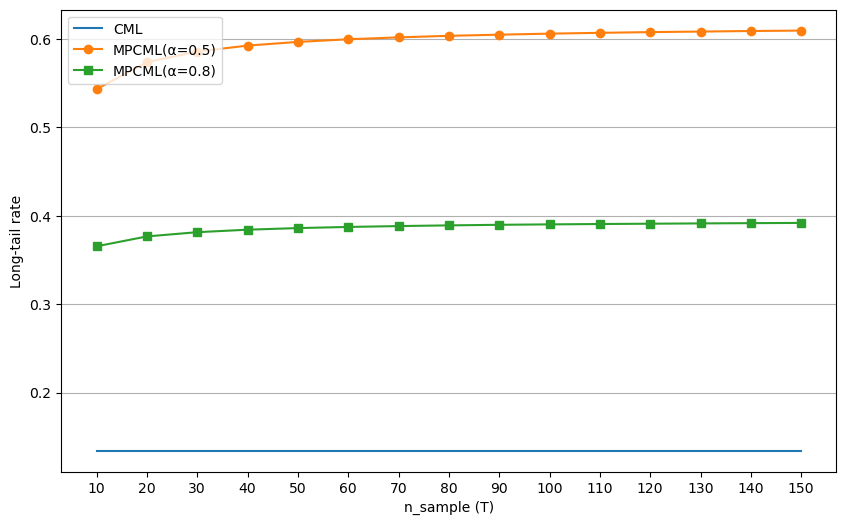

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, longtale_base, label='CML')
plt.plot(n_sample_li, longtale_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, longtale_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (T)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()